# **Predicting Automobile-related Killed and Seriously Injured (KSI) Incidents in Toronto**

The aim of this project is to develop a machine learning model to analyze and identify trends in automobile-related KSI incidents within Toronto. It utilizes the Automobile-related KSI Collisions dataset (2006-2024) provided by Toronto Police Service through their Public Safety Data Portal to predict the likelihood of fatal or non-fatal Automobile-related KSI occurrences in Toronto.

**Author:** Brian Nguyen  
**Last Updated:** 2025-02-04  

# Import Libraries and Define Auxiliary Functions

In [1]:
# Pandas is a software library written in Python for data manipulation and analysis.
import pandas as pd
# NumPy is a library which provides support for large, multi-dimensional arrays, matrices and mathematical operations.
import numpy as np
# Matplotlib is a plotting library for python; pyplot offers a MATLAB-style framework for plotting.
import matplotlib.pyplot as plt
# Seaborn is a data visualization library based on matplotlib, allowing users to create complex statistical graphs.
import seaborn as sns

# Preprocessing and transformation
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_selector as selector

# Provides tools to split data into training and testing sets and perform hyperparameter tuning with cross-validation
from sklearn.model_selection import train_test_split, GridSearchCV

# Shows cross-validated training and test scores for different training set sizes
from sklearn.model_selection import learning_curve

# ConfusionMatrixDisplay is used to plot a confusion matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Pipeline class allows users to chain together multiple preprocessing and modeling steps
from sklearn.pipeline import Pipeline

# SMOTE is a method used to handle class imbalance in datasets by generating samples of minority classes.
from imblearn.over_sampling import SMOTE

def plot_all_feature_importances(importances, std, feature_names, title = "Feature Importances"):
    forest_importances = pd.Series(importances, index = feature_names)

    fig, ax = plt.subplots(figsize = (12, 6))
    forest_importances.plot.bar(yerr = std, ax = ax)
    ax.set_title(title, fontsize=14, fontweight = 'bold')
    ax.set_ylabel("Mean Decrease in Impurity", fontsize=12, fontweight = 'bold')
    ax.set_xlabel("Features", fontsize = 12, fontweight='bold')
    plt.xticks(rotation=45, ha = 'right')
    plt.tight_layout()
    plt.show()

def plot_feature_importances(importances, std, feature_names, top_n = 12, title="Top 12 Important Features"):
    forest_importances = pd.Series(importances, index=feature_names)
    top_features = forest_importances.nlargest(top_n)
    top_std = std[np.argsort(importances)[-top_n:]]

    fig, ax = plt.subplots(figsize=(8, 6))
    top_features.plot.bar(yerr=top_std, ax=ax)
    ax.set_title(title, fontsize=14, fontweight='bold')
    ax.set_ylabel("Mean Decrease in Impurity", fontsize=12, fontweight='bold')
    ax.set_xlabel("Features", fontsize=12, fontweight='bold')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# Function to evaluate a trained classification model using key metrics and visualize its ROC curve
def evaluate_model(model, X_test, y_test, X_full=None, y_full=None, title="Model", threshold = 0.5):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
    from sklearn.model_selection import cross_val_score
    
    y_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= threshold).astype(int)

    cm = confusion_matrix(y_test, y_pred)
    
    print(f"\n--- {title} Evaluation ---")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("F1 Score:", f1_score(y_test, y_pred))
    print("Recall:", recall_score(y_test, y_pred))

    # Compute a confusion matrix using sckit-learn to evaluate the accuracy of a classification
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp.plot(ax=ax, cmap='plasma', colorbar=True, values_format='.0f')
    plt.title(f"Confusion Matrix for {title}", fontsize=14, fontweight='bold')
    plt.grid(False)
    plt.tight_layout()
    plt.show()
    
    if X_full is not None and y_full is not None:
        cv_scores = cross_val_score(model, X_full, y_full, cv=3, scoring='accuracy')
        print("\nCross-Validation Scores:", cv_scores)
        print("Mean CV Accuracy:", np.mean(cv_scores))
        print("Standard Deviation:", np.std(cv_scores))
    
    roc_auc = roc_auc_score(y_test, y_proba)
    print("ROC AUC Score:", roc_auc)

    # Generate the ROC curve to evaluate the model's performance and ability to distinguish between classes at various decision thresholds
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="#4c72b0", lw=2.5, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="#7f7f7f", linestyle="--", linewidth=1.5)
    plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold')
    plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold')
    plt.title(f"ROC Curve for {title} Classifier", fontsize=14, fontweight='bold')
    plt.grid(alpha=0.3, linestyle='--')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# Function to plot the learning curve of a trained model which shows training and cross-validation accuracy across varying training set sizes
def plot_learning_curve(estimator, X, y, title="Learning Curve", cv=3, scoring="accuracy"):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, scoring=scoring, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 5), shuffle=True, random_state=42
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(8, 6))
    plt.title(title)
    plt.xlabel("Number of samples in the training set", fontsize=12, fontweight='bold')
    plt.ylabel(scoring.capitalize(), fontsize=12, fontweight='bold')
    plt.grid(True)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1)
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1)
    plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Score")
    plt.plot(train_sizes, test_scores_mean, 'o-', label="Test Score")
    plt.legend(loc="best")
    plt.tight_layout()
    plt.show()

# *Exploratory Data Analysis (EDA)*

This section loads the dataset and performs initial data inspection, including:
- Checking dataset dimensions and column names
- Reviewing data types, missing values, and summary statistics
- Inspecting unique values in categorical columns
- Visualizing distributions of key categorical features

Dataset Dimensions (Rows, Columns): (17230, 54)

List of Column Names: Index(['OBJECTID', 'INDEX', 'ACCNUM', 'DATE', 'TIME', 'STREET1', 'STREET2',
       'OFFSET', 'ROAD_CLASS', 'DISTRICT', 'LATITUDE', 'LONGITUDE', 'ACCLOC',
       'TRAFFCTL', 'VISIBILITY', 'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE',
       'INVTYPE', 'INVAGE', 'INJURY', 'FATAL_NO', 'INITDIR', 'VEHTYPE',
       'MANOEUVER', 'DRIVACT', 'DRIVCOND', 'PEDTYPE', 'PEDACT', 'PEDCOND',
       'CYCLISTYPE', 'CYCACT', 'CYCCOND', 'PEDESTRIAN', 'CYCLIST',
       'AUTOMOBILE', 'MOTORCYCLE', 'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH',
       'PASSENGER', 'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL', 'DISABILITY',
       'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140',
       'DIVISION', 'x', 'y'],
      dtype='object')

Unique values per column:
OBJECTID             17230
INDEX                17230
ACCNUM                4392
DATE                  3827
TIME                  1314
STREET1               1766
STREET2        

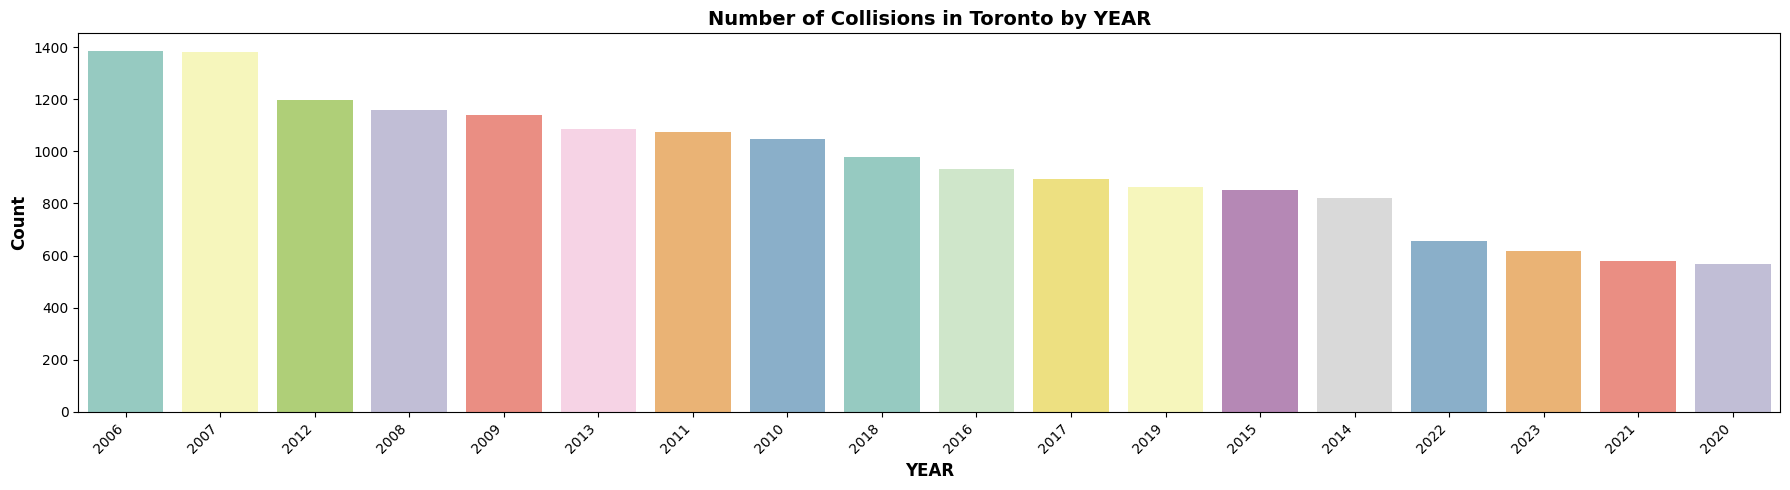

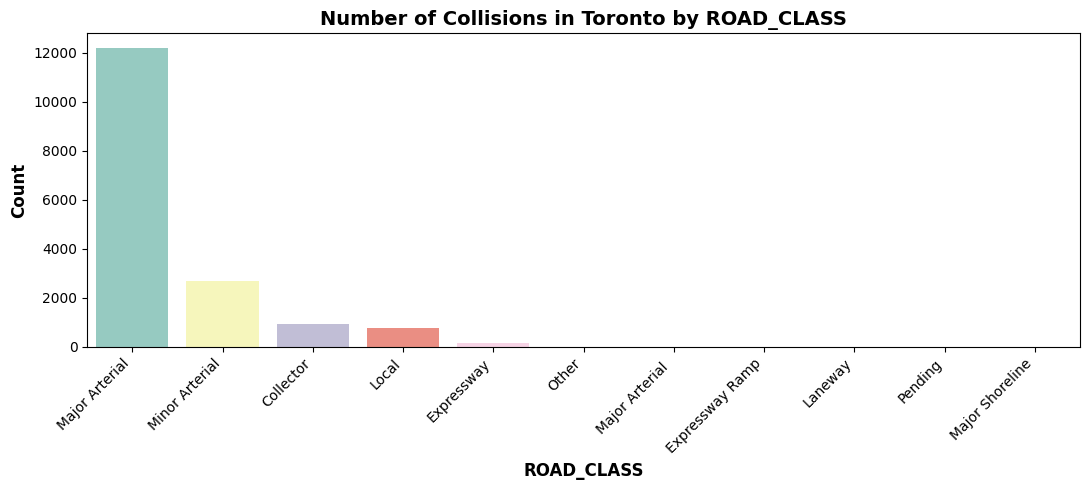

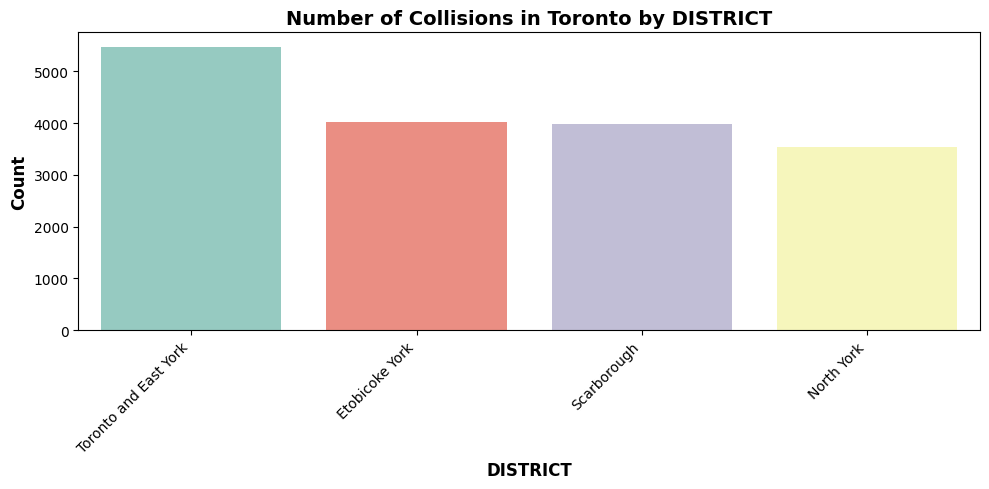

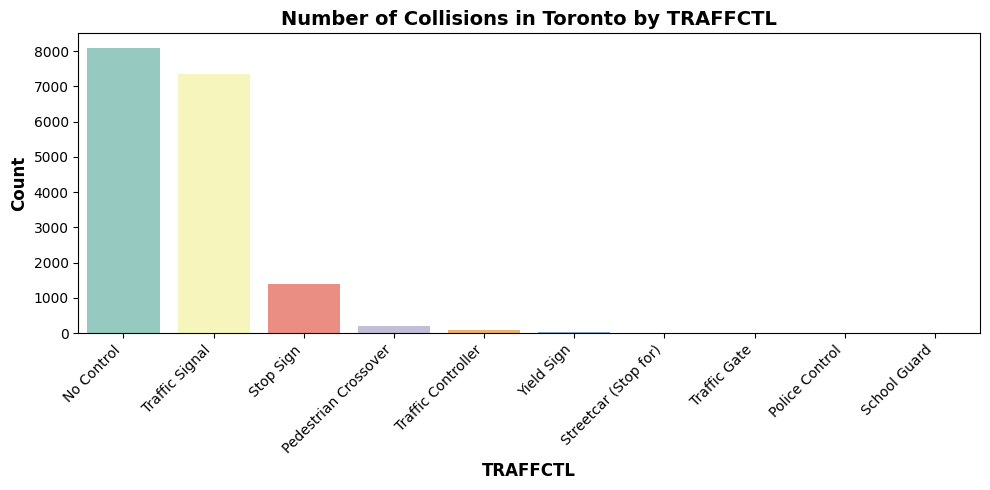

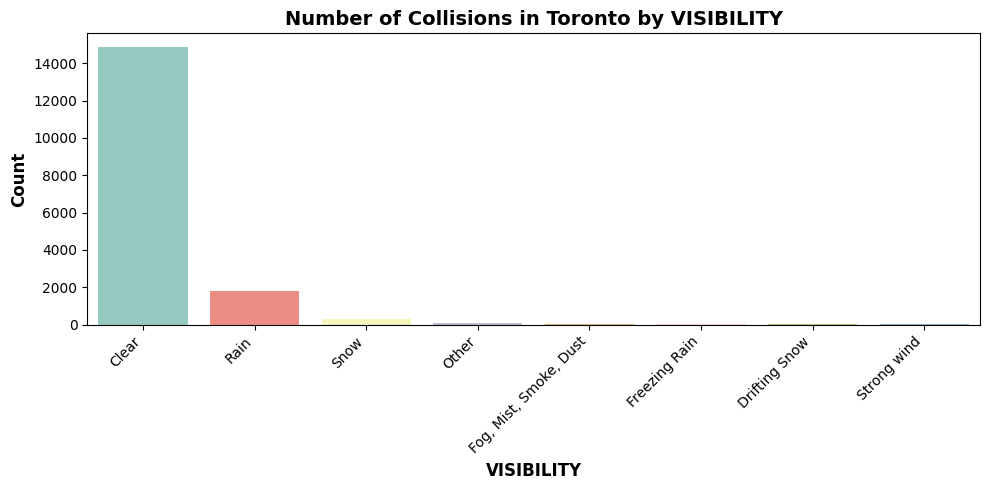

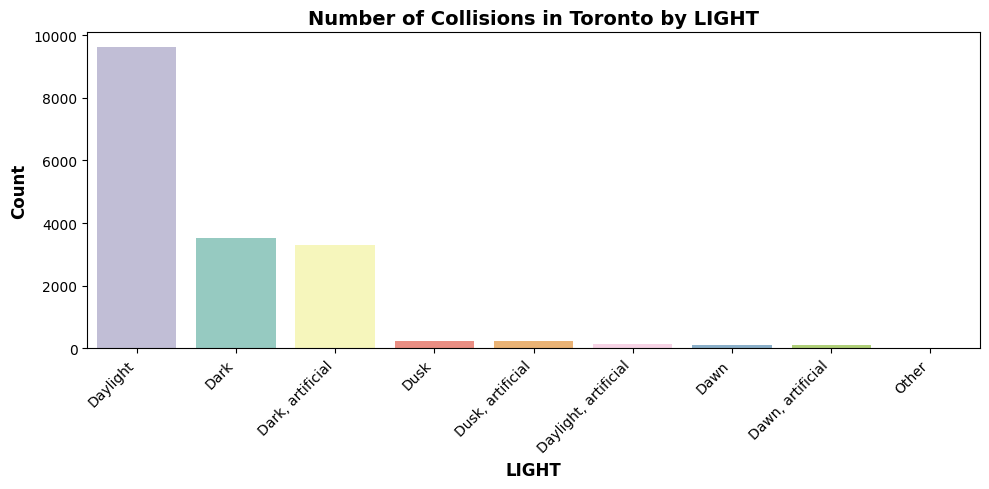

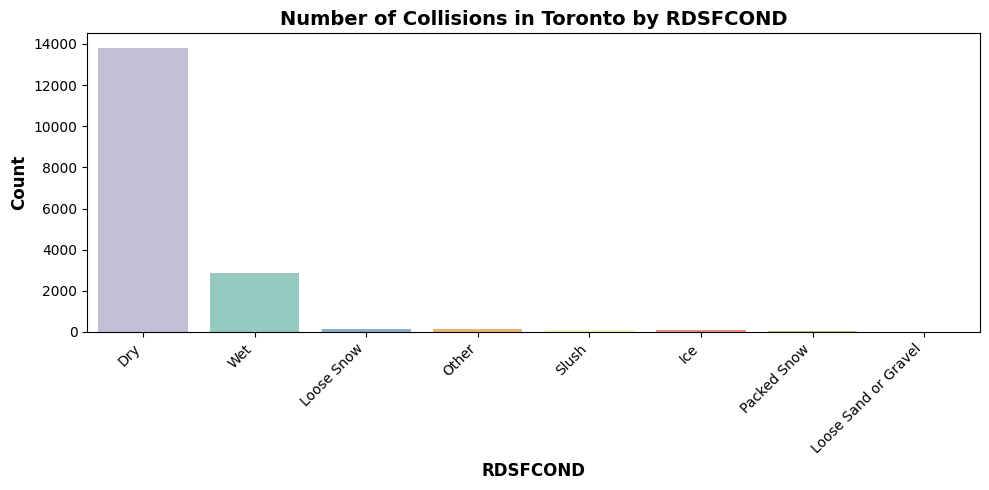

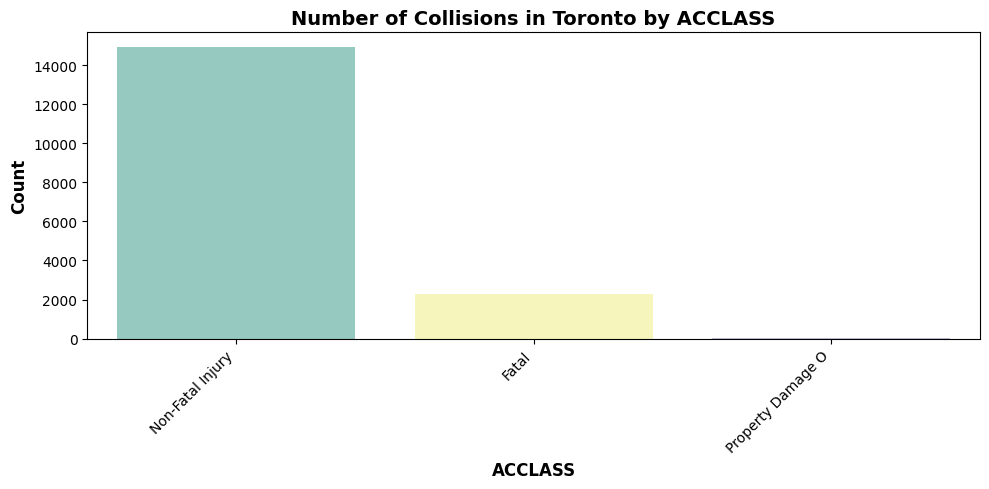

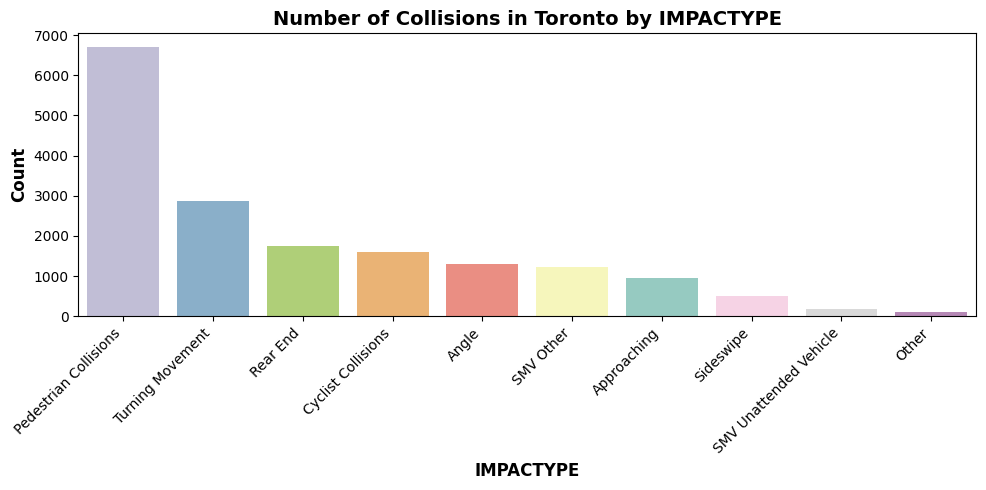

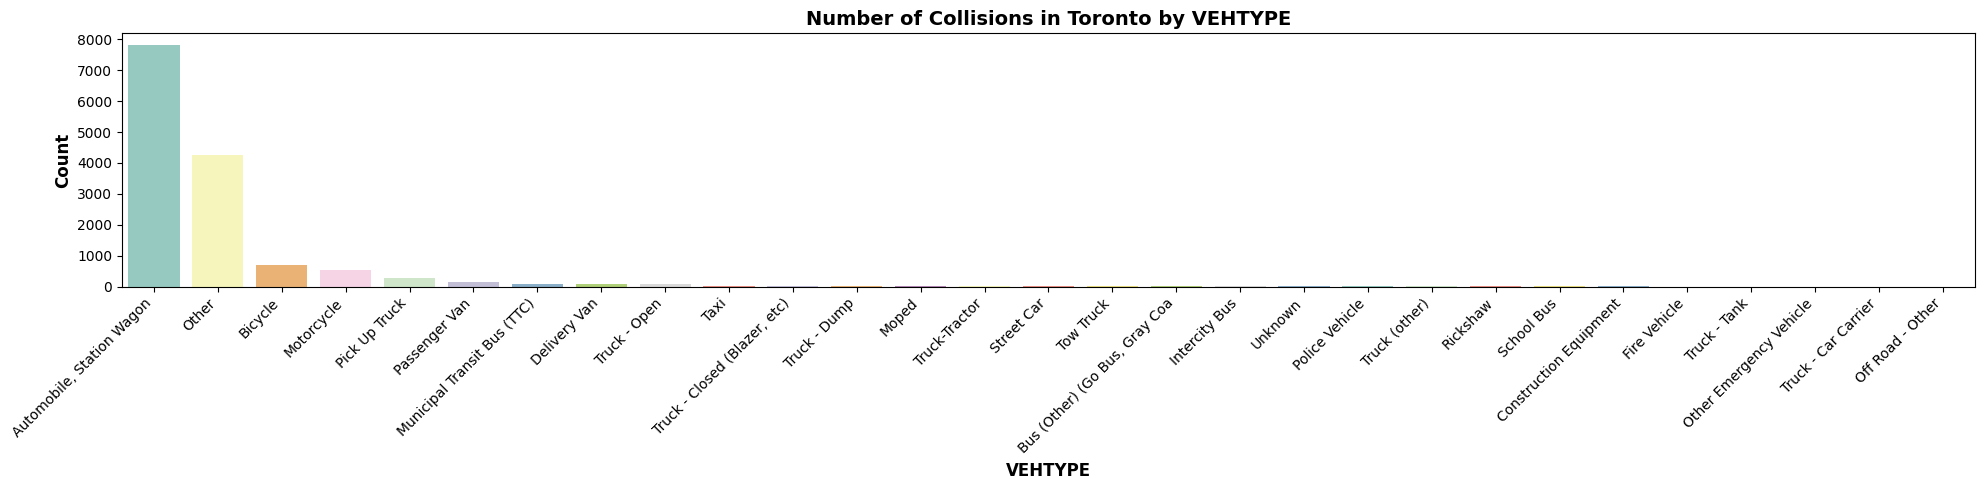

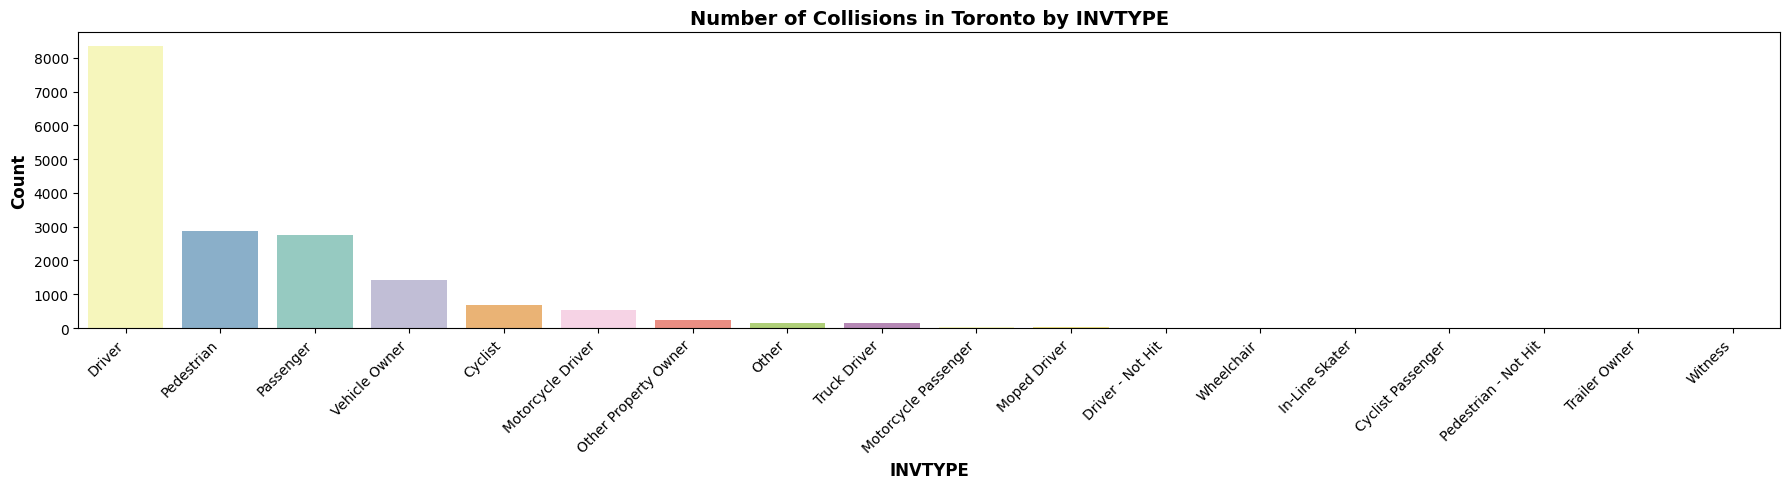

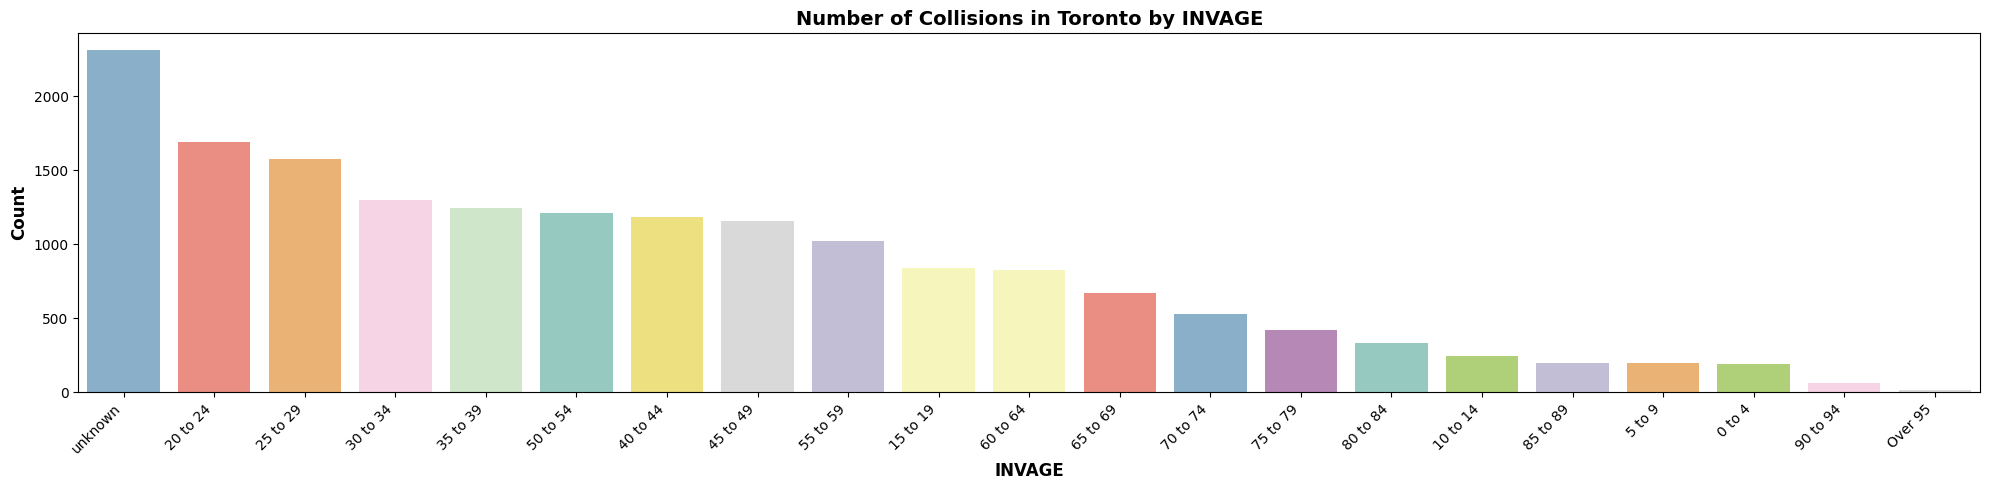

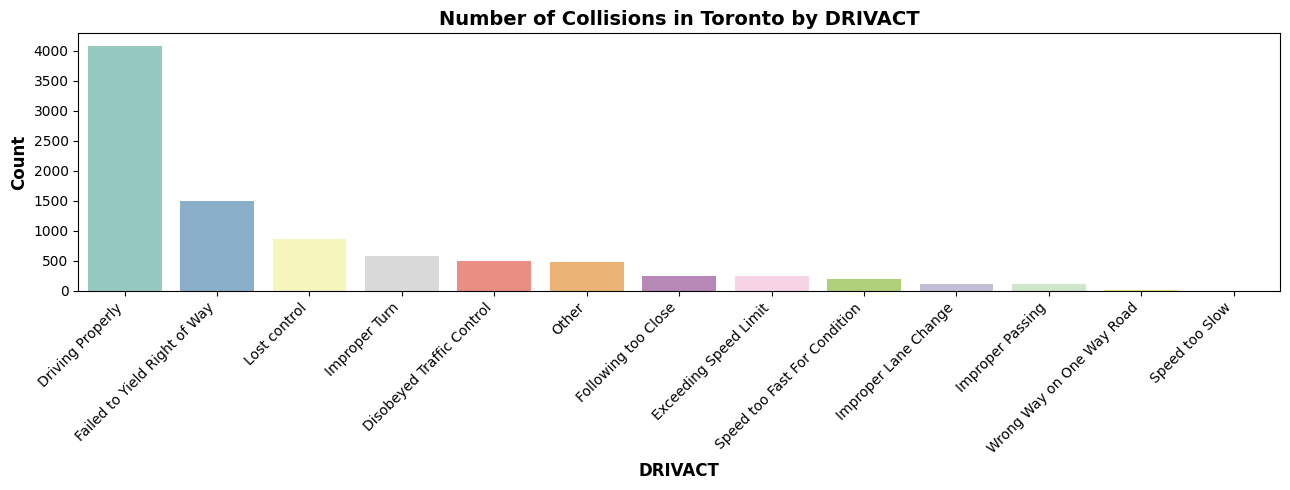

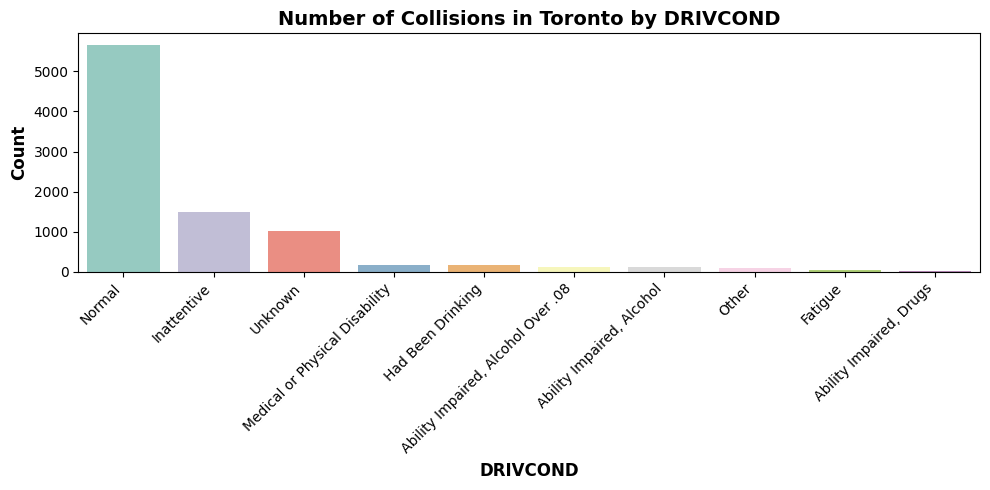

In [2]:
# Load the CSV dataset file
df = pd.read_csv("Automobile_KSI_Collisions.csv")

# Dataset description 
print("Dataset Dimensions (Rows, Columns):", df.shape)
print("\nList of Column Names:", df.columns)

# Display all unique values in a column.
print("\nUnique values per column:")
print(df.nunique())

print("\nData Types & Non-Null (Missing) Value Counts:")
df.info()

print("\nSummary Statistics:")
print(df.describe())

print("\nExtracting Unique Values from Categorical Columns:")
for col in df.select_dtypes(include='object'):
    print(f"\n{col}:")
    print(df[col].unique())

# Identify Missing Values
print("\n")
print(df.isnull().sum())

# Convert DATE to datetime and extract YEAR, MONTH, DAY
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['YEAR'] = df['DATE'].dt.year
df['MONTH'] = df['DATE'].dt.month
df['WEEKDAY'] = df['DATE'].dt.weekday

# Visualize key categorical features
visualize = [
    'YEAR', 'ROAD_CLASS', 'DISTRICT', 'TRAFFCTL', 'VISIBILITY',
    'LIGHT', 'RDSFCOND', 'ACCLASS', 'IMPACTYPE', 'VEHTYPE',
    'INVTYPE', 'INVAGE', 'DRIVACT', 'DRIVCOND',
]
palette_color = "Set3"

# Generate count plots for each column
for col in visualize:
    if col in df.columns:
        n_unique = df[col].nunique()
        plt.figure(figsize = (max(10, min(n_unique, 20)), 5))  # Adjusts width based on # of categories
        sns.countplot(data = df, x = col, hue = col, order = df[col].value_counts().index, palette=palette_color, legend=False)
        plt.title(f'Number of Collisions in Toronto by {col}', fontweight='bold', fontsize = 14)
        plt.xlabel(col, fontweight = 'bold', fontsize = 12)
        plt.ylabel('Count', fontweight = 'bold', fontsize = 12)
        plt.xticks(rotation=45, ha = 'right', fontsize=10)
        plt.tight_layout()
        plt.show()

# *Data Cleaning*

- Reclassifying `"Property Damage Only"` entries as `"Non-Fatal Injury"` to support binary classification  
- Filtering the dataset to include only `"Fatal"` and `"Non-Fatal Injury"` cases  
- Filling missing values in binary categorical columns (e.g., PEDESTRIAN, ALCOHOL) with `"No"`  
- Dropping irrelevant or redundant columns
- Applying label encoding to convert the target column (`ACCLASS`) into a binary numeric format

In [3]:
# Replace 'Property Damage Only' with 'Non-Fatal Injury' to create binary classification
df['ACCLASS'] = df['ACCLASS'].replace('Property Damage O', 'Non-Fatal Injury')

# Filter only 'Fatal' and 'Non-Fatal Injury'
df = df[df['ACCLASS'].isin(['Fatal', 'Non-Fatal Injury'])].copy()
     
# Fill 'Yes/No' fields with 'No' where there is missing value
binary_col = ['PEDESTRIAN', 'CYCLIST', 'AUTOMOBILE', 'MOTORCYCLE',
              'TRUCK', 'TRSN_CITY_VEH', 'EMERG_VEH', 'PASSENGER',
              'SPEEDING', 'AG_DRIV', 'REDLIGHT', 'ALCOHOL',
              'DISABILITY']
df[binary_col] = df[binary_col].fillna('No')

# Remove irrelevant or unused columns
remove_col = ['OBJECTID', 'INDEX', 'ACCNUM', 'DATE', 'TIME', 'STREET1',
              'STREET2', 'OFFSET', 'ACCLOC', 'FATAL_NO', 'PEDTYPE', 
              'PEDACT', 'PEDCOND', 'CYCLISTYPE', 'CYCACT', 'CYCCOND', 
              'HOOD_158', 'NEIGHBOURHOOD_158', 'HOOD_140', 'NEIGHBOURHOOD_140', 
              'x', 'y']

df = df.drop(columns=[col for col in remove_col if col in df.columns])

df['ACCLASS'] = df['ACCLASS'].map({'Non-Fatal Injury': 0, 'Fatal': 1})

print("Fatal vs Non-Fatal Distribution (%):")
print(df['ACCLASS'].value_counts(normalize=True).map(lambda x: f"{x:.2%}"))

# Split dataset into x (input features) and y (target collision severity)
X = df.drop('ACCLASS', axis=1)
y = df['ACCLASS']

Fatal vs Non-Fatal Distribution (%):
ACCLASS
0    86.74%
1    13.26%
Name: proportion, dtype: object


# *Model Building*

In this step, we build and evaluate four classification models: Logistic Regression, Random Forest, XGBoost and LightGBM. Each model is trained using a preprocessing pipeline that includes imputation for missing values, categorical encoding, and feature scaling. To help the models better detect fatal KSI cases, SMOTE (Synthetic Minority Over-sampling Technique) is applied to balance the dataset. Additionally, hyperparameters are tuned using grid search with cross-validation. Model performance is assessed using standard evaluation metrics, including Accuracy, Precision, Recall, F1 Score, and ROC AUC.

# *1. Logistic Regression Model*

This section builds a Logisitc Regression model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. Logistic regression is a supervised machine learning algorithm which uses the sigmoid function to map predictions between 0 and 1, making it well-suited for binary classification tasks. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: 79.74% — Indicates overall strong correctness
- Precision: 36.32% — Poor reliability with a notable rate of false positives
- F1 Score: 47.83% — Decent balance between precision and recall
- Recall: 70.02% — Captures the majority of fatal cases
- ROC AUC Score: 0.8461 — Demonstrates strong ability to distinguish between fatal and non-fatal outcomes

Fitting 3 folds for each of 8 candidates, totalling 24 fits

--- Logistic Regression Evaluation ---
Accuracy: 0.7974463145676146
Precision: 0.36322360953461974
F1 Score: 0.47832585949177875
Recall: 0.700218818380744


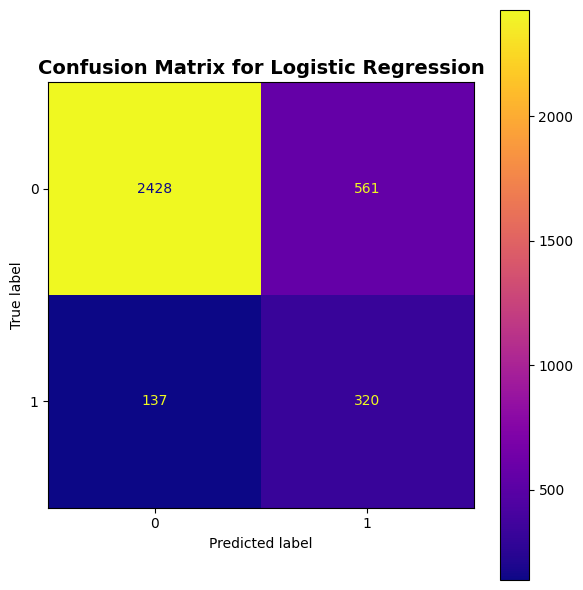


Cross-Validation Scores: [0.90527599 0.90684311 0.88664461]
Mean CV Accuracy: 0.8995879041151547
Standard Deviation: 0.009174624465806277
ROC AUC Score: 0.8461389793209677


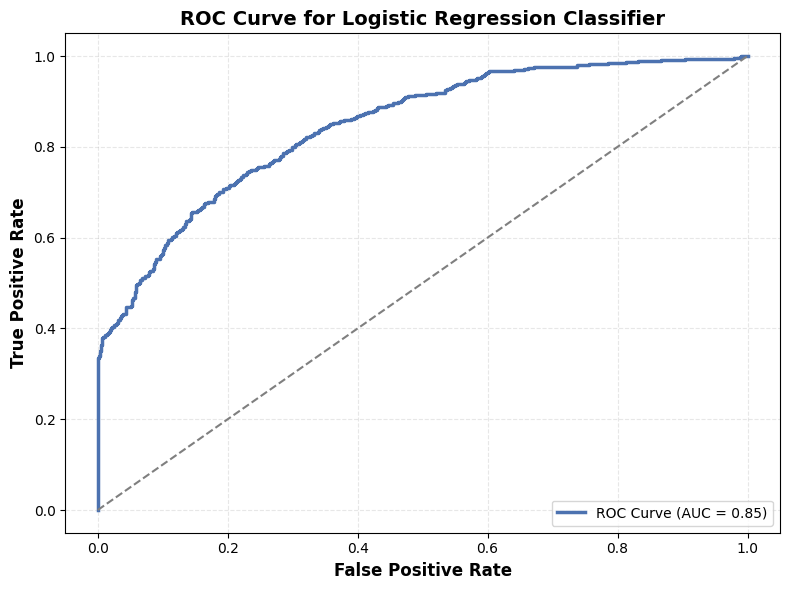

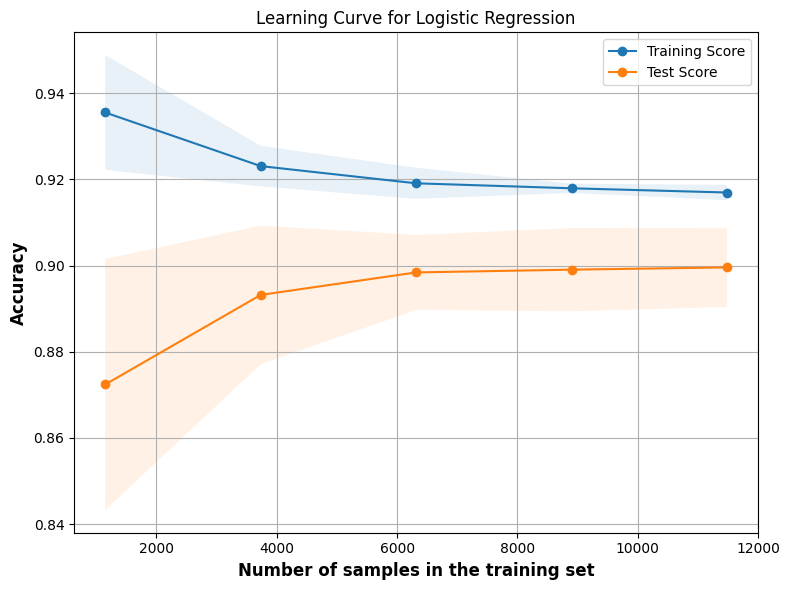

In [4]:
from sklearn.linear_model import LogisticRegression

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown = 'ignore', sparse_output = False))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include = 'object')),
    ('num', num_pipeline, selector(dtype_exclude = 'object'))
])

# Apply preprocessing
X_processed = preprocessor.fit_transform(X)

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, stratify=y, test_size = 0.2, random_state=42)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Logistic Regression setup
logreg_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(max_iter=500, solver = 'lbfgs', penalty = 'l2'))
])

param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10],
    'logreg__solver': ['lbfgs', 'liblinear'],
    'logreg__penalty': ['l2']
}

# Setup GridSearchCV
grid_search = GridSearchCV(
    estimator = logreg_pipeline,
    param_grid = param_grid,
    scoring = 'recall',
    cv=3,
    verbose = 1,
    n_jobs = -1
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid_search.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
logreg_model = grid_search.best_estimator_

# Call upon the evaluation function to assess Logistic Regression model performance
evaluate_model(logreg_model, X_test, y_test, X_full=X_processed, y_full = y, title = "Logistic Regression")

# Call upon the learning curve function to visualize model performance across training set sizes
plot_learning_curve(logreg_model, X_processed, y, title = "Learning Curve for Logistic Regression")

# *2. Random Forest Classifier*

This section builds a Random Forest classification model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. Random Forest is a supervised machine learning algorithm that combines multiple decision trees trained on random subsets of the data and features. It aggregates the results from multiple trees to improve robustness and reduce overfitting, while also highlighting the most important features by eliminating less important features through impurity calculations. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: 94.54% — Showcases strong overall correctness
- Precision: 88.98% — Low rate of false positives for fatal cases
- F1 Score: 76.55% — High balance of precision and recall
- Recall: 67.17% — Only a moderate portion of fatal cases were correctly identified
- ROC AUC Score: 0.943 — Demonstrates strong ability to distinguish between fatal and non-fatal outcomes

Fitting 3 folds for each of 6 candidates, totalling 18 fits


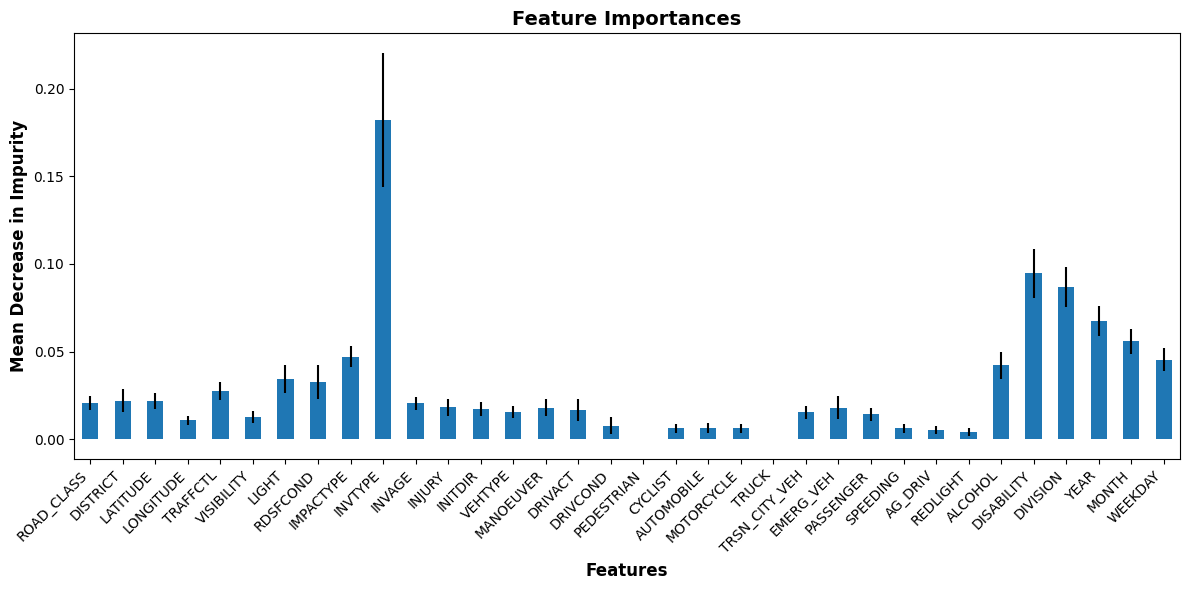

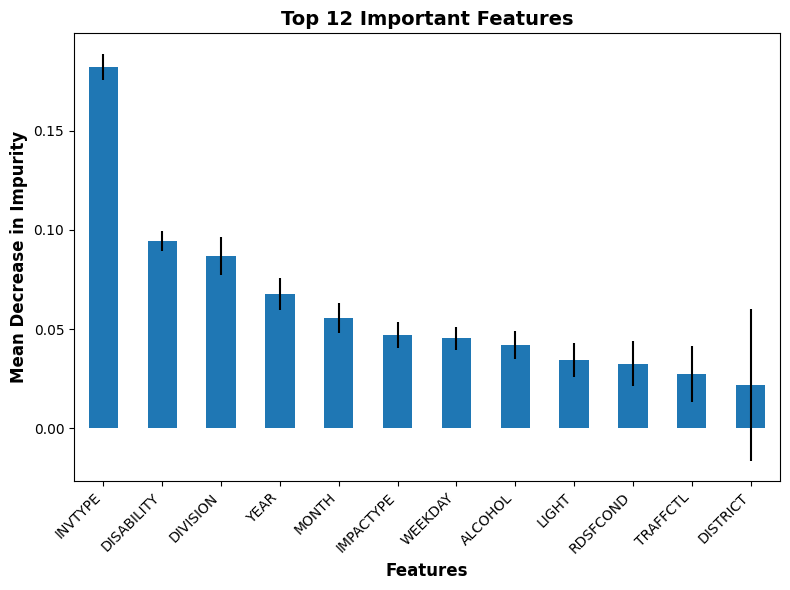


--- Random Forest Evaluation ---
Accuracy: 0.9454439930354034
Precision: 0.8898550724637682
F1 Score: 0.7655860349127181
Recall: 0.6717724288840262


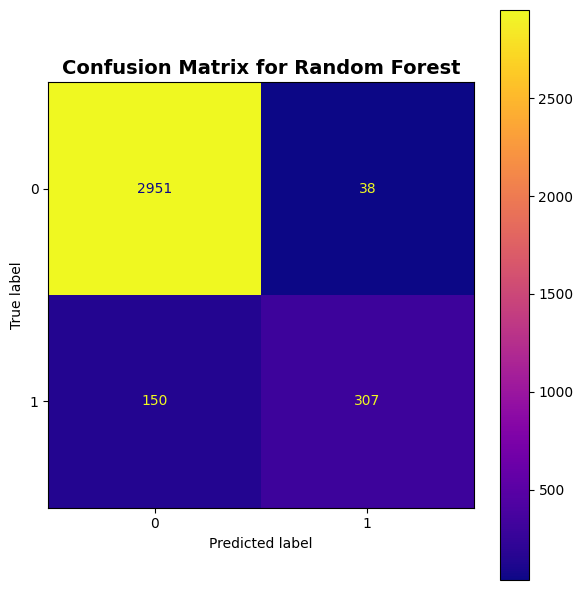


Cross-Validation Scores: [0.90753961 0.90980324 0.31133554]
Mean CV Accuracy: 0.7095594636949331
Standard Deviation: 0.2815883540430906
ROC AUC Score: 0.943547566459952


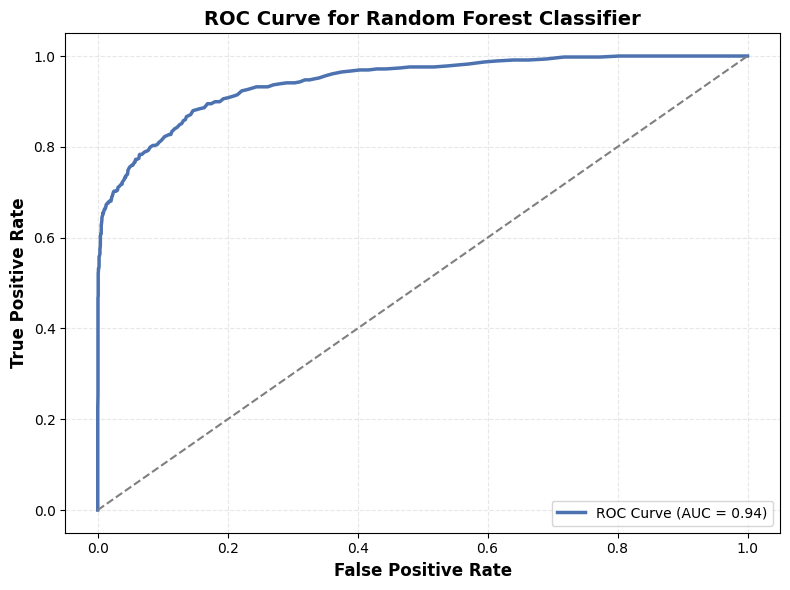

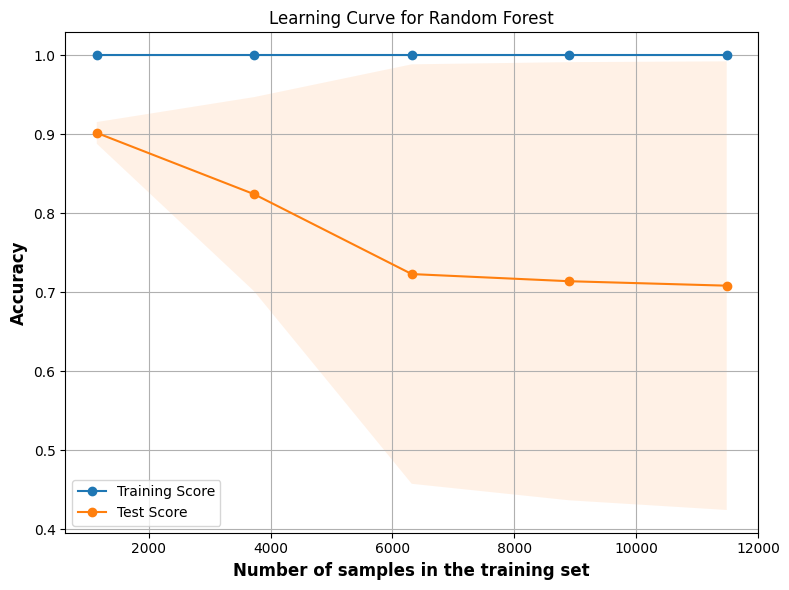

In [5]:
# from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'most_frequent')),
    ('ordinal', OrdinalEncoder())
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy = 'median')),
    ('scaler', MinMaxScaler())
])

preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include = 'object')),
    ('num', num_pipeline, selector(dtype_exclude = 'object'))
])

# Apply preprocessing
X_rf_processed = preprocessor.fit_transform(X)

rf_temp = RandomForestClassifier(random_state=13, n_jobs=-1, class_weight='balanced')
rf_temp.fit(X_rf_processed, y)

importances = rf_temp.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf_temp.estimators_], axis=0)
feature_names = X.columns
top_n = 12
important_indices = np.argsort(importances)[-top_n:]
X_selected = X_rf_processed[:, important_indices]

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, stratify=y, random_state=13)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=13).fit_resample(X_train, y_train)

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10],
    'min_samples_split': [2],
    'max_features': ['sqrt']
}

grid = GridSearchCV(
    estimator = RandomForestClassifier(random_state=13, class_weight='balanced'),
    param_grid = param_grid,
    scoring = 'recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
rf_model = grid.best_estimator_

# Call upon the feature importance function to visualize feature importance for all features
plot_all_feature_importances(importances, std, feature_names=X.columns)

# Call upon the feature importance function to visualize the top 12 most important features
plot_feature_importances(importances, std, feature_names=X.columns, top_n = 12)

# Call upon the evaluation function to assess Random Forest model performance
evaluate_model(rf_model, X_test, y_test, X_full=X_selected, y_full=y, title="Random Forest", threshold = 0.43)

# Call upon the learning curve function to visualize model performance across training set sizes
plot_learning_curve(rf_model, X_selected, y, title="Learning Curve for Random Forest")

# *3. XGBoost Model*

This section builds a XGBoost classification model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. XGBoost is a gradient boosting framework which operates by building sequential decision trees, which is particualrly helpful when working with tabular data similar to the current dataset. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:
- Accuracy: ~95.70 — Indicates strong overall overall correctness
- Precision: ~86.01% — Low rate of false positives for fatal cases
- F1 Score: ~83.29% — Balanced trade-off between precision and recall.
- Recall: ~80.74% — Successfully captures the majority of fatal cases.
- ROC AUC Score: ~0.9552 — Strong ability to distinguish between fatal and non-fatal

Fitting 3 folds for each of 16 candidates, totalling 48 fits

--- XGBoost Evaluation ---
Accuracy: 0.9570516540917006
Precision: 0.8601398601398601
F1 Score: 0.8329571106094809
Recall: 0.8074398249452954


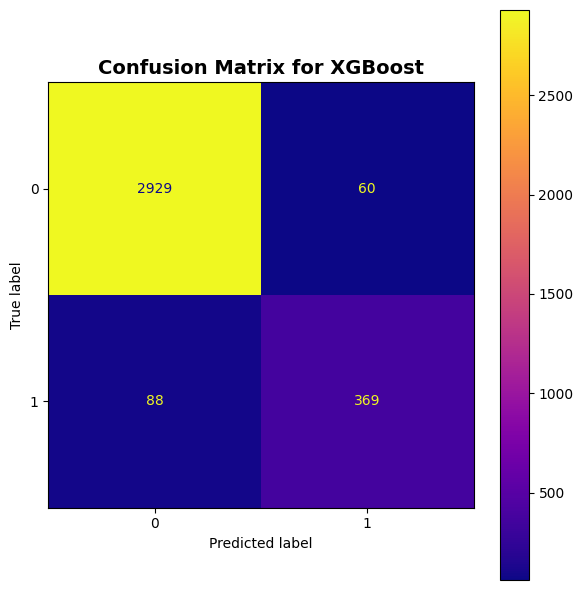


Cross-Validation Scores: [0.90753961 0.84137211 0.25840153]
Mean CV Accuracy: 0.6691044169713855
Standard Deviation: 0.2916643954909206
ROC AUC Score: 0.9552604626885012


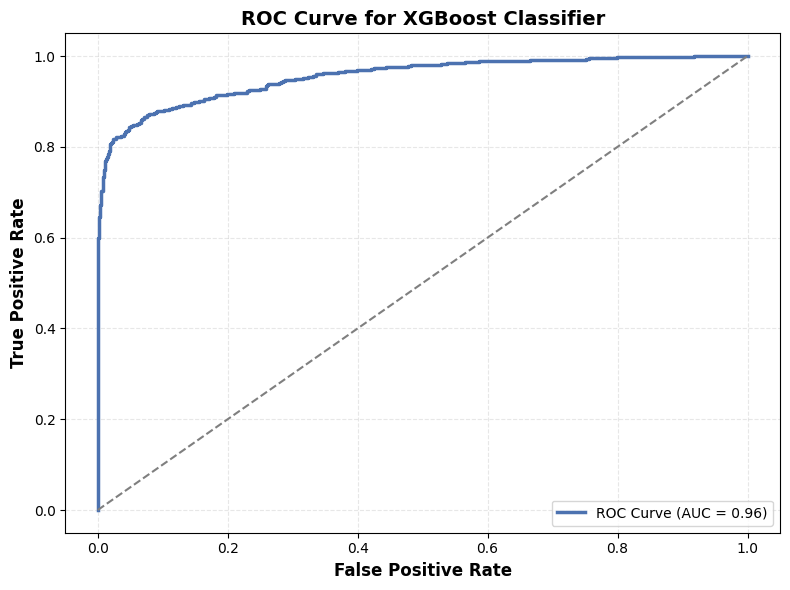

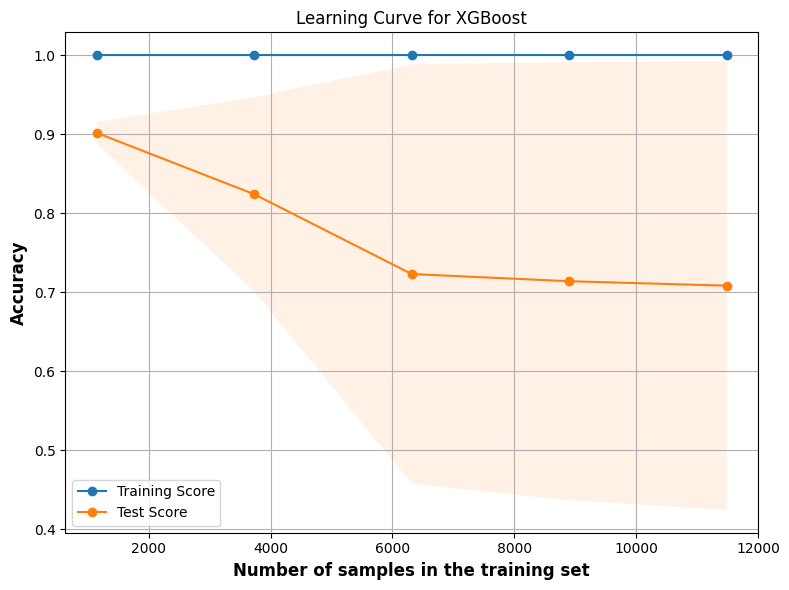

In [6]:
from xgboost import XGBClassifier

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include='object')),
    ('num', num_pipeline, selector(dtype_exclude='object'))
])

# Apply preprocessing
X_processed_oe = preprocessor.fit_transform(X)

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_oe, y, test_size=0.2, stratify=y, random_state=13)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Initialize and train XGBoost model
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [6, 10],
    'learning_rate': [0.1],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [1.0]
}

grid_search = GridSearchCV(
    estimator=XGBClassifier(
        objective='binary:logistic',
        eval_metric='auc',
        random_state=42,
    ),
    param_grid=param_grid,
    scoring = 'recall',
    cv=3,
    n_jobs=-1,
    verbose=1,
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid_search.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
xgb_model = grid_search.best_estimator_

# Call upon the evaluation function to assess XGBoost model performance
evaluate_model(xgb_model, X_test, y_test, X_full=X_processed_oe, y_full=y, title="XGBoost", threshold=0.2)

# Call upon the learning curve function to visualize model performance across training set sizes
plot_learning_curve(rf_model, X_selected, y, title="Learning Curve for XGBoost")

# 4. LightGBM Model
This section builds a LightGBM classification model to predict the likelihood of a traffic collision resulting in fatality vs non-fatal injury. LightGBM is a histogram-based gradient boosting algorithm that was chosen for its efficiency and ability to build complex trees using optimal split points, resulting in higher accuracy and faster training speeds on larger datasets. The model is trained using features related to road conditions, environmental factors, vehicle types and driver behaviors. To address the class imbalance inherent in the dataset, SMOTE (Synthetic Minority Over-sampling Technique) is applied during training.

Key Evaluation Metrics:

- Accuracy: ~95.85 — Reflects strong overall overall correctness
- Precision: ~89.84% — Very low rate of false positives for fatal cases
- F1 Score: ~83.19% — Maintains solid balance between precision and recall.
- Recall: ~77.46% — Effectively captures the majority of fatal cases.
- ROC AUC Score: ~0.9522 — Strong ability to distinguish between fatal and non-fatal

Fitting 3 folds for each of 324 candidates, totalling 972 fits

--- LightGBM Evaluation ---
Accuracy: 0.9585026117237376
Precision: 0.8984771573604061
F1 Score: 0.8319623971797885
Recall: 0.774617067833698


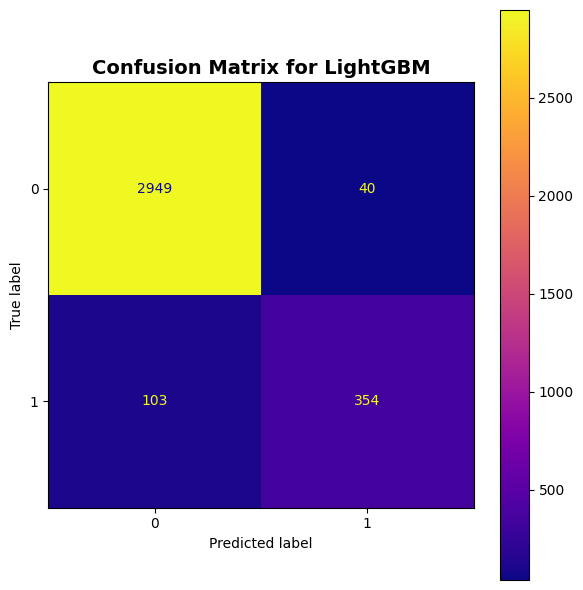


Cross-Validation Scores: [0.90632074 0.70572871 0.24621278]
Mean CV Accuracy: 0.6194207440942597
Standard Deviation: 0.2763119348895501
ROC AUC Score: 0.9522889544668891


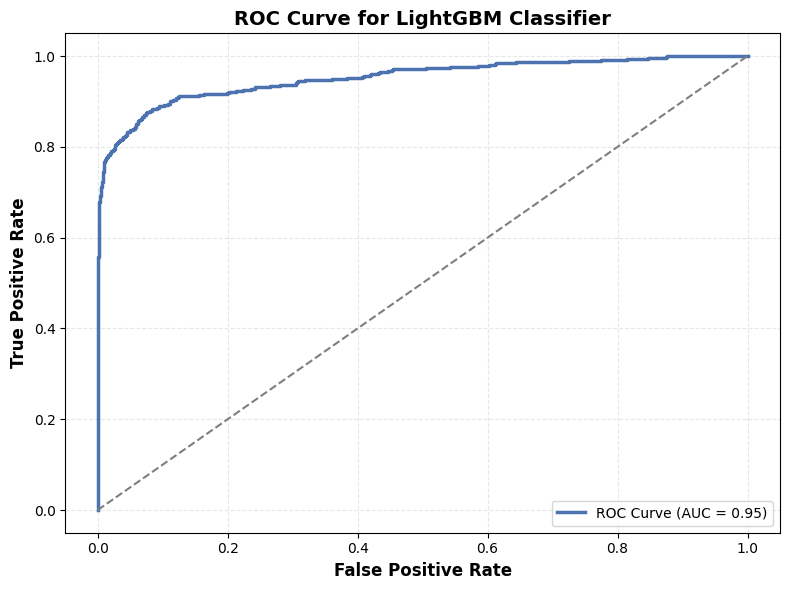

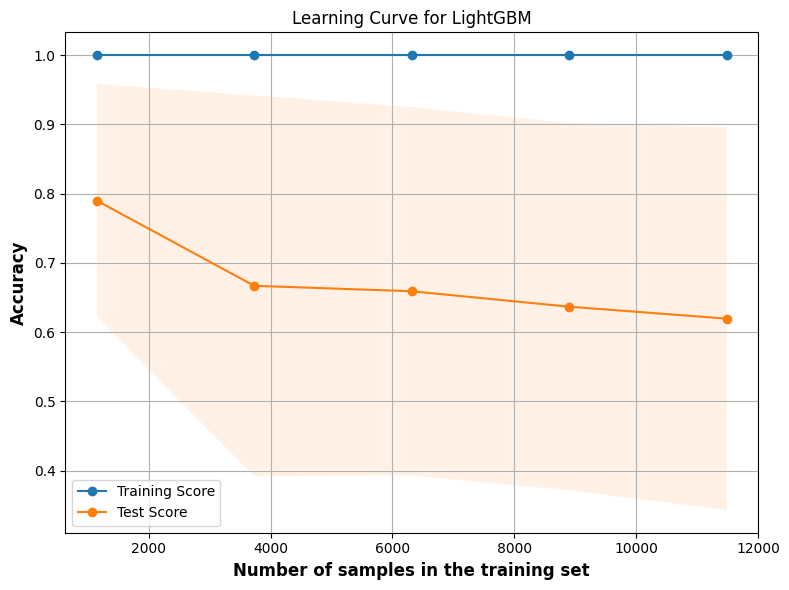

In [7]:
from lightgbm import LGBMClassifier

# Define Preprocessing pipelines
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', MinMaxScaler())
])
preprocessor = ColumnTransformer([
    ('cat', cat_pipeline, selector(dtype_include='object')),
    ('num', num_pipeline, selector(dtype_exclude='object'))
])

# Apply preprocessing
X_processed_lgb = pd.DataFrame(
    preprocessor.fit_transform(X),
    columns=preprocessor.get_feature_names_out()
)

# Split preprocessed data into stratified training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed_lgb, y, test_size=0.2, stratify=y, random_state=13)

# Apply SMOTE to balance classes
X_train_bal, y_train_bal = SMOTE(random_state=42).fit_resample(X_train, y_train)

# Initialize and train LightGBM model
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [6, 10, -1],
    'learning_rate': [0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

grid_search = GridSearchCV(
    estimator=LGBMClassifier(
        objective='binary',
        class_weight='balanced',
        random_state=42,
        verbose=-1
    ),
    param_grid=param_grid,
    scoring = 'recall',
    cv=3,
    n_jobs=-1,
    verbose=1
)
# Fits the grid search across the hyperparameter grid using cross-validation
grid_search.fit(X_train_bal, y_train_bal)

# Retrieves the best-performing model from the grid search
lgbm_model = grid_search.best_estimator_

# Call upon the evaluation function to assess LightGBM model performance
evaluate_model(lgbm_model, X_test, y_test, X_full=X_processed_lgb, y_full=y, title="LightGBM", threshold=0.317)

# Call upon the learning curve function to visualize model performance across training set sizes
plot_learning_curve(lgbm_model, X_processed_lgb, y, title="Learning Curve for LightGBM")